# Simple prediction of XTB stock price using LR and DTR

With more than 15 years experience, XTB is one of the largest stock exchange-listed FX & CFD brokers in the world. It has offices in over 13 countries including UK, Poland, Germany, France and Chile. 

According to the company financial reports, its main profits come from FX, comodities, and CFD contracts. So, the more volatility on the global financial market, the better for the profits. Keeping that in mind, I choose some key fundamental indicators (indices) or possible underlying products (USD/EUR, gold, oil). That seems to be the most promising for my analysis. What is essential due to the different timezones is that some of them can be treated as leading indicators, which is beneficial for the practical application of such research.

- X-Trade Brokers SA (XTB)
- WIG (WIG)\-S&P 500 
- U.S. (^SPX)
- S&P 500 VIX Nov 2020 (VIX20.F)
- U.S. Dollar / Euro 1:1 (USDEUR)
- Gold - COMEX (GC.F)
- Crude Oil WTI - NYMEX (CL.F)

In [39]:
# Importing key libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("bmh")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import  mean_squared_error, r2_score

## Data and quick exploration

In [40]:
# Downloading data
xtb = pd.read_csv("Data/xtb_d.csv", index_col="Data", parse_dates=True)
wig = pd.read_csv("Data/wig_d.csv", index_col="Data", parse_dates=True)
spx = pd.read_csv("Data/spx_d.csv", index_col="Data", parse_dates=True)
gld = pd.read_csv("Data/gc_f_d.csv", index_col="Data", parse_dates=True)
oil = pd.read_csv("Data/cl_f_d.csv", index_col="Data", parse_dates=True)
usd = pd.read_csv("Data/usdeur_d.csv", index_col="Data", parse_dates=True)
vix = pd.read_csv("Data/vix20_f_d.csv", index_col="Data", parse_dates=True)

A quick look at the chart illustrates how significantly the Covid 19 outbreak has impacted the stock quotations. The uncertainty and market volatility have contributed to stock price growth. Whats more, the company attracted new investors with significant capital and noted unprecedented trade volume levels. 

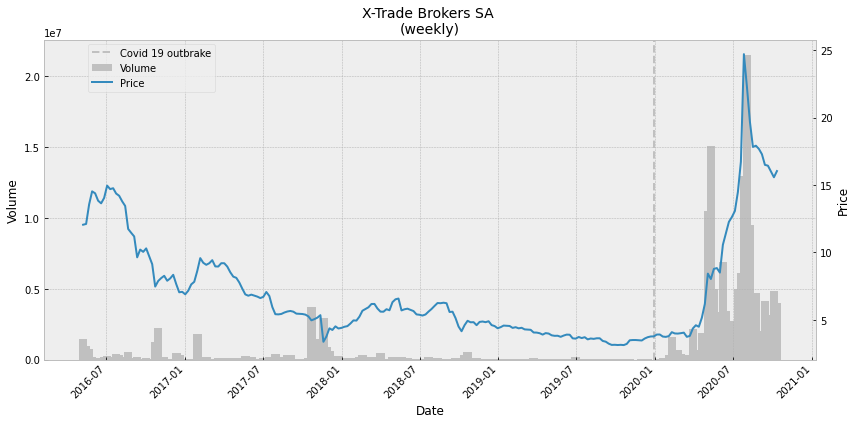

In [41]:
# Plotting the closing price and volume, weekly view
price = xtb.Zamkniecie.resample("W").mean()
volume = xtb.Wolumen.resample("W").sum()

fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate(rotation=45)

ax.bar(volume.index, volume, color="silver", width=20)
ax.set(xlabel="Date", ylabel="Volume", yscale="linear")
ax.set_title(label="X-Trade Brokers SA \n(weekly)", fontsize=14)
ax.axvline("2019-12-30", color="silver", linestyle="--", linewidth=2)

ax2 = ax.twinx()
ax2.plot(price.index, price, linewidth=2)
ax2.set(ylabel="Price", yscale="linear")

fig.legend(["Covid 19 outbrake", "Volume", "Price"], 
           loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.grid()
plt.tight_layout()
plt.show()

In [42]:
# constructing dataset
dataset = pd.concat([xtb["Zamkniecie"], 
                     wig["Zamkniecie"], 
                     spx["Zamkniecie"], 
                     gld["Zamkniecie"], 
                     oil["Zamkniecie"], 
                     usd["Zamkniecie"], 
                     vix["Zamkniecie"]], axis=1).dropna()

dataset.columns = ["xtb", "wig", "spx", "gld", "oil", "usd", "vix"]
dataset.head()

,xtb,wig,spx,gld,oil,usd,vix
Data,,,,,,,
2019-12-09,3.84000,55867.95,3135.96,1464.9,59.02,0.90372,19.125
2019-12-10,3.63000,55609.32,3132.52,1468.1,59.24,0.90144,19.450
2019-12-11,3.65003,55531.27,3141.63,1475.0,58.76,0.89821,19.475
2019-12-12,3.69000,56621.06,3168.57,1472.3,59.18,0.89415,19.125
2019-12-13,3.75000,56729.11,3168.80,1481.2,60.07,0.89954,18.975


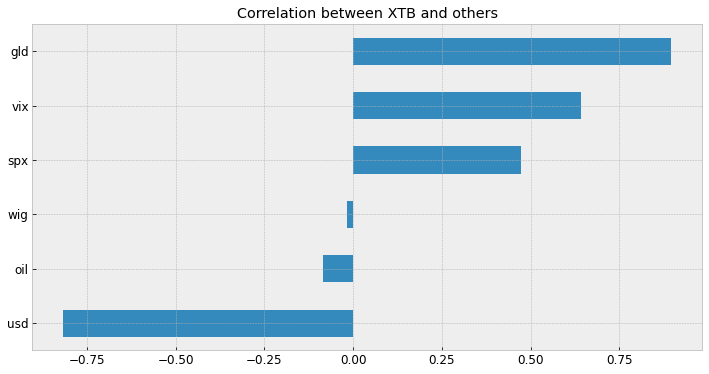

In [43]:
# Correlation between variables
cor = dataset.corr()
cor.xtb.sort_values(ascending=True)[:-1].plot(kind="barh",
                                         figsize=(12,6),
                                         title="Correlation between XTB and others",
                                         fontsize=12)
plt.show()

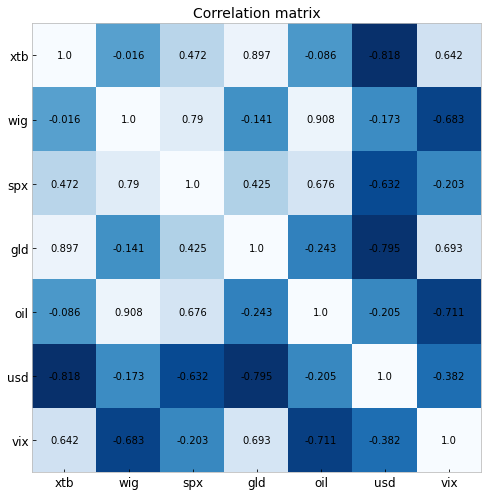

In [44]:
fig,ax =plt.subplots(figsize=(7,7))

ax.imshow(cor, cmap="Blues_r")
ax.set_title("Correlation matrix", fontsize=14)
ax.set_xticks(np.arange(len(cor.columns)))
ax.set_xticklabels(cor.columns, fontsize=12)
ax.set_yticks(np.arange(len(cor.index.values)))
ax.set_yticklabels(cor.index.values, fontsize=12)

for i in range(len(cor.index.values)):
    for c in range(len(cor.columns.values)):
        text = ax.text(i, c, cor.iloc[i,c].round(3), 
                       ha="center", va="center", color="black")

plt.grid(False)
plt.tight_layout()
plt.show()

## Models training

In [45]:
# Chosing features and labels
labels = dataset["xtb"].values
features = dataset.drop("xtb", axis=1).values

In [46]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=42)

### Linear Regression

In [47]:
# Applying Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [48]:
# Measuring LR results
print("LR results:")
print("MSE: %.4f" % mean_squared_error(y_test, predictions))
print("RMSE: %.4f" % (np.sqrt(mean_squared_error(y_test, predictions))))
print('R2: %.4f' % r2_score(y_test, predictions))

LR results:
MSE: 5.1621
RMSE: 2.2720
R2: 0.8701


In [49]:
# Features importance
pd.Series(index=dataset.drop("xtb", axis=1).columns, 
          data=lr.coef_,name="Coef").sort_values()

usd   -56.810021
spx    -0.006017
wig     0.000579
gld     0.021590
oil     0.043219
vix     0.583309
Name: Coef, dtype: float64

In [50]:
# Grid search
param = {"fit_intercept":[True, False], "normalize":[True, False]}

gs_lr = GridSearchCV(lr, param)
gs_lr.fit(X_train, y_train)
print("Best params:", gs_lr.best_params_)
print("Best score:", gs_lr.best_score_)

Best params: {'fit_intercept': False, 'normalize': True}
Best score: 0.8867927122203085


### DecisionTree Regressor

In [51]:
# Applying DTR results
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
predictions = dtr.predict(X_test)

In [52]:
# Measuring DTR results
print("DTR results:")
print("MSE: %.4f" % mean_squared_error(y_test, predictions))
print("RMSE: %.4f" % (np.sqrt(mean_squared_error(y_test, predictions))))
print('R2: %.4f' % r2_score(y_test, predictions))

DTR results:
MSE: 3.2556
RMSE: 1.8043
R2: 0.9181


In [53]:
# Features importance
pd.Series(index=dataset.drop("xtb", axis=1).columns, 
          data=dtr.feature_importances_ ,name="Coef").sort_values()

usd    0.000424
vix    0.003640
oil    0.003699
spx    0.039280
wig    0.061985
gld    0.890971
Name: Coef, dtype: float64

In [54]:
# Grid search
param = {"max_features":["auto", "sqrt", "log2"]}

gs_dtr = GridSearchCV(dtr, param)
gs_dtr.fit(X_train, y_train)
print("Best params:", gs_dtr.best_params_)
print("Best score:", gs_dtr.best_score_)

Best params: {'max_features': 'sqrt'}
Best score: 0.9291325236064096


## Results

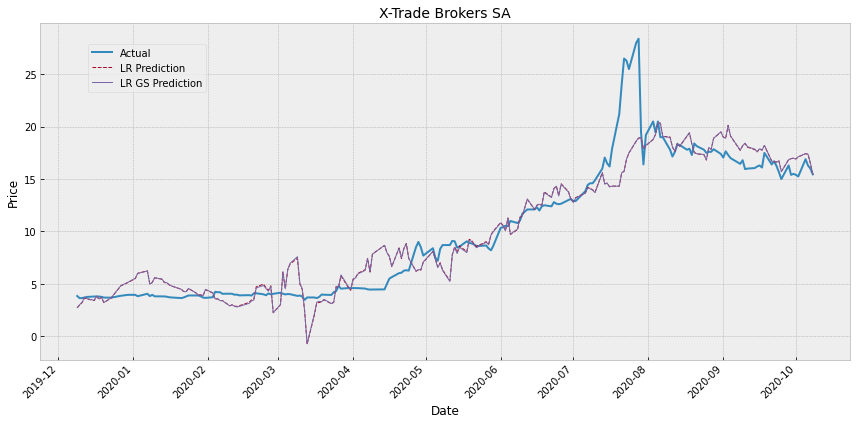

In [55]:
# Plotting LR results
fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate(rotation=45)

ax.set(xlabel="Date", ylabel="Price", yscale="linear")
ax.set_title(label="X-Trade Brokers SA", fontsize=14)

ax.plot(dataset.index, dataset.xtb, linewidth=2)
ax.plot(dataset.index, 
        pd.Series(lr.predict(dataset.drop("xtb",axis=1).values)), 
        linewidth=1, ls="--")

ax.plot(dataset.index, 
        pd.Series(gs_lr.predict(dataset.drop("xtb",axis=1).values)), 
        linewidth=1, ls="-")

fig.legend(["Actual", "LR Prediction", "LR GS Prediction"], 
           loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()

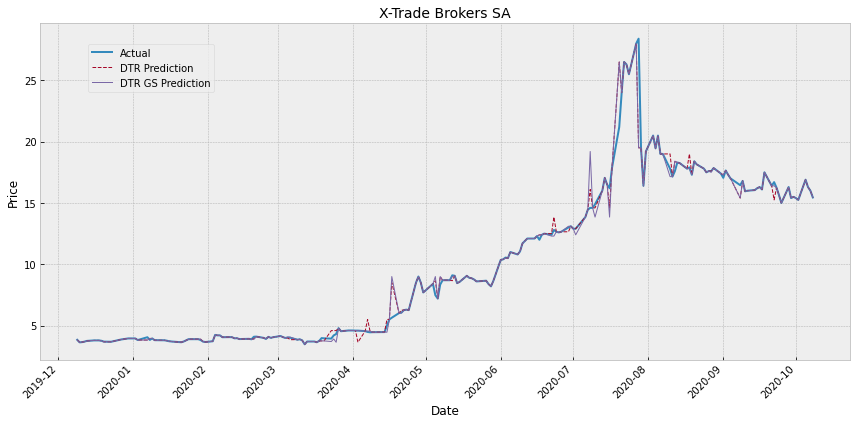

In [56]:
# Plotting DTR results
fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate(rotation=45)

ax.set(xlabel="Date", ylabel="Price", yscale="linear")
ax.set_title(label="X-Trade Brokers SA", fontsize=14)

ax.plot(dataset.index, dataset.xtb, linewidth=2)
ax.plot(dataset.index, 
        pd.Series(dtr.predict(dataset.drop("xtb",axis=1).values)), 
        linewidth=1, ls="--")

ax.plot(dataset.index, 
        pd.Series(gs_dtr.predict(dataset.drop("xtb",axis=1).values)), 
        linewidth=1, ls="-")

fig.legend(["Actual", "DTR Prediction", "DTR GS Prediction"], 
           loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()